## 1. Import thư viện

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import shutil
import random
import pickle
import json
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



2025-12-01 12:46:11.804969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 12:46:11.851451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 12:46:12.945031: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Import các thư viện cần thiết
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.20.0
Keras version: 3.11.3


## 2. Khám phá và trực quan hóa dữ liệu

In [3]:
DATASET_PATH = './Dataset'  # Ví dụ đường dẫn trên Colab
# Lấy danh sách các loại hoa
flower_classes = sorted([d for d in os.listdir(DATASET_PATH)
                        if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Số lượng loài hoa: {len(flower_classes)}")
print(f"\nCác loài hoa: ")
for i, flower in enumerate(flower_classes, 1):
    print(f"{i}. {flower}")

Số lượng loài hoa: 113

Các loài hoa: 
1. Aconitum_napellus
2. Adenium_obesum
3. Alpinia_purpurata
4. Alstroemeria_aurea
5. Anemone_coronaria
6. Anemone_hupehensis
7. Anthurium_andraeanum
8. Antigonon_leptopus
9. Antirrhinum_majus
10. Aquilegia_vulgaris
11. Astrantia_major
12. Barringtonia_acutangula
13. Bauhinia_purpurea
14. Bidens_pilosa
15. Bombax_ceiba
16. Bougainvillea_glabra
17. Bromelia_pinguin
18. Calendula_officinalis
19. Callistephus_chinensis
20. Camellia_japonica
21. Campanula_medium
22. Campsis_radicans
23. Canna_indica
24. Catharanthus_roseus
25. Cattleya_labiata
26. Cautleya_spicata
27. Cirsium_vulgare
28. Clematis_vitalba
29. Convolvulus_cneorum
30. Crocus_vernus
31. Curcuma_alismatifolia
32. Cyclamen_persicum
33. Dahlia_pinnata
34. Dahlia_x_pinnata
35. Datura_stramonium
36. Dendrobium_anosmum
37. Dendrobium_phalaenopsis
38. Dendromecon_rigida
39. Dianthus_barbatus
40. Dianthus_caryophyllus
41. Digitalis_purpurea
42. Echinacea_purpurea
43. Echinops_ritro
44. Echinopsis_

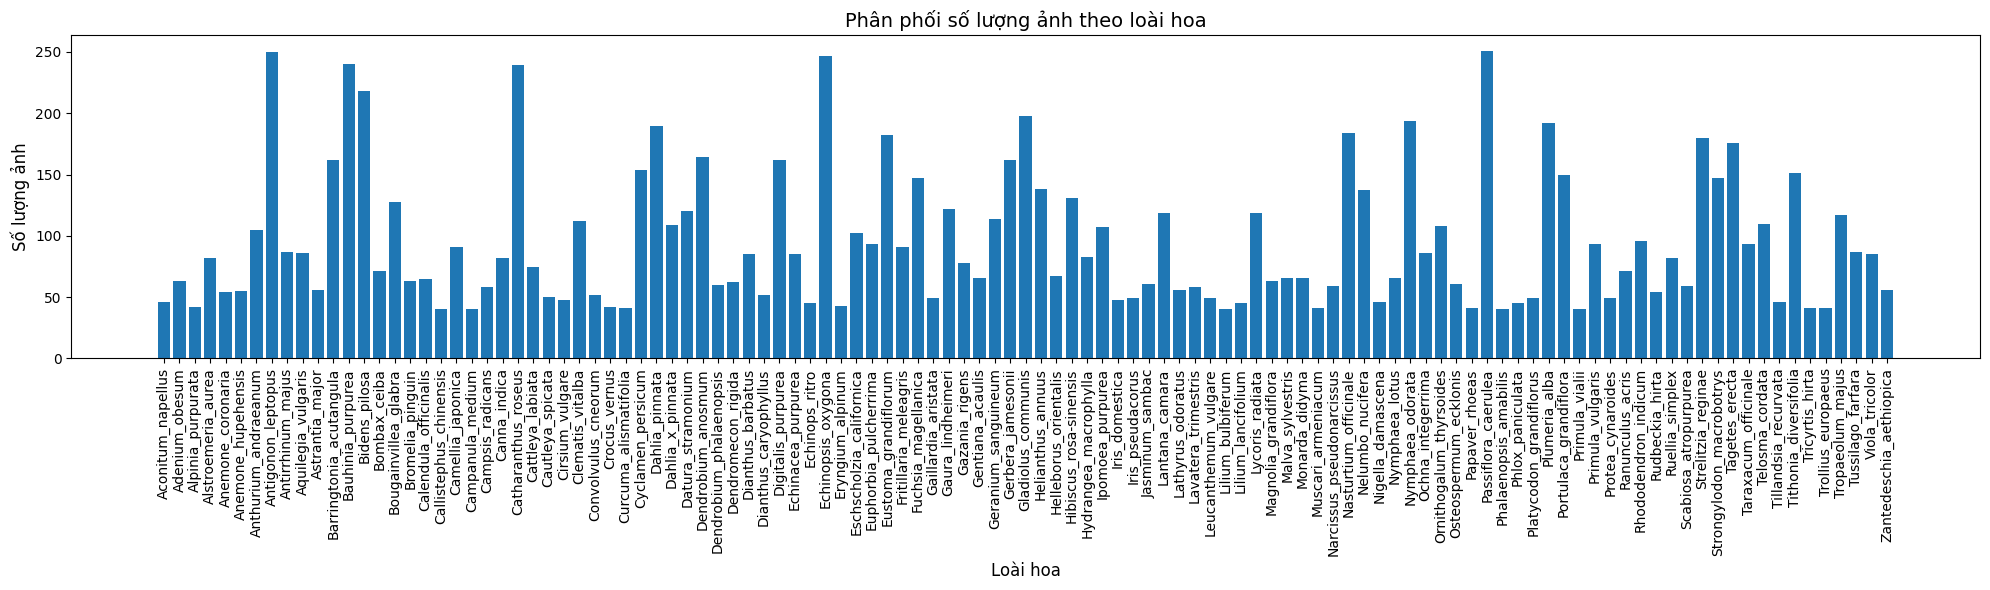


Tổng số ảnh: 10814
Trung bình: 95.70 ảnh/loài
Min: 40 - Max: 251


In [4]:
# Đếm số lượng ảnh cho mỗi loài hoa
flower_counts = {}
for flower in flower_classes:
    flower_path = os.path.join(DATASET_PATH, flower)
    count = len([f for f in os.listdir(flower_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    flower_counts[flower] = count

# Vẽ biểu đồ phân phối
plt.figure(figsize=(20, 6))
plt.bar(range(len(flower_counts)), list(flower_counts.values()))
plt.xlabel('Loài hoa', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.title('Phân phối số lượng ảnh theo loài hoa', fontsize=14)
plt.xticks(range(len(flower_counts)), list(flower_counts.keys()), rotation=90)
plt.tight_layout()
plt.show()

print(f"\nTổng số ảnh: {sum(flower_counts.values())}")
print(f"Trung bình: {np.mean(list(flower_counts.values())):.2f} ảnh/loài")
print(f"Min: {min(flower_counts.values())} - Max: {max(flower_counts.values())}")

## 3. Chuẩn bị dữ liệu - Chia Train/Val/Test

In [ ]:
# Tạo thư mục cho train/val/test
def create_split_directories(base_path='data_split'):
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path, exist_ok=True)

        for flower_class in flower_classes:
            os.makedirs(os.path.join(split_path, flower_class), exist_ok=True)

    return base_path

# Chia dữ liệu theo tỷ lệ 70% train, 15% val, 15% test
def split_data(dataset_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    for flower_class in flower_classes:
        flower_path = os.path.join(dataset_path, flower_class)
        images = [f for f in os.listdir(flower_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Shuffle
        random.shuffle(images)

        # Tính toán số lượng
        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Copy files
        for split_name, split_images in [('train', train_images),
                                         ('val', val_images),
                                         ('test', test_images)]:
            for img in split_images:
                src = os.path.join(flower_path, img)
                dst = os.path.join(output_path, split_name, flower_class, img)
                shutil.copy2(src, dst)

        print(f"{flower_class}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

# Tạo và chia dữ liệu
SPLIT_PATH = create_split_directories('data_split')
split_data(DATASET_PATH, SPLIT_PATH)

In [ ]:
import os
import matplotlib.pyplot as plt

DATA_SPLIT_PATH = './data_split'
splits = ['train', 'val', 'test']

split_counts = {}
for split in splits:
    split_path = os.path.join(DATA_SPLIT_PATH, split)
    total_images = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            total_images += len(os.listdir(cls_path))
    split_counts[split] = total_images

plt.figure(figsize=(6, 4))
plt.bar(split_counts.keys(), split_counts.values())
plt.title("Số lượng ảnh theo từng tập dữ liệu")
plt.ylabel("Số lượng ảnh")
plt.xlabel("Tập dữ liệu")
plt.show()

split_counts


In [ ]:
train_path = os.path.join(DATA_SPLIT_PATH, 'train')
class_counts = {cls: len(os.listdir(os.path.join(train_path, cls)))
                for cls in os.listdir(train_path)
                if os.path.isdir(os.path.join(train_path, cls))}

plt.figure(figsize=(12, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Số lượng ảnh mỗi lớp (Train Set)")
plt.xticks(rotation=90)
plt.xlabel("Loài hoa")
plt.ylabel("Số lượng ảnh")
plt.tight_layout()
plt.show()

class_counts


In [ ]:
plt.figure(figsize=(6,6))
plt.pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%')
plt.title("Tỷ lệ phân chia Train/Val/Test")
plt.show()


## 4. Data Augmentation Class (MixUp & CutMix)

In [5]:
class DataAugmentation:
    def __init__(self, num_classes, mixup_alpha=0.2):

        self.num_classes = num_classes
        self.mixup_alpha = mixup_alpha
    
    def mixup(self, image1, image2, label1, label2):

        if self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        else:
            lam = 1.0
        
        # Mix images
        mixed_image = lam * image1 + (1 - lam) * image2
        
        # Mix labels
        mixed_label = lam * label1 + (1 - lam) * label2
        
        return mixed_image, mixed_label
    
    def apply_augmentation(self, batch_images, batch_labels):
        batch_size = len(batch_images)
        augmented_images = []
        augmented_labels = []

        # Tạo một permutation ngẫu nhiên của batch để trộn
        indices = np.random.permutation(batch_size)

        for i in range(batch_size):
            j = indices[i]  # Chọn ảnh khác để MixUp
            aug_image, aug_label = self.mixup(
                batch_images[i], batch_images[j],
                batch_labels[i], batch_labels[j]
            )
            augmented_images.append(aug_image)
            augmented_labels.append(aug_label)

        return np.array(augmented_images), np.array(augmented_labels)

In [6]:
# Thiết lập tham số
IMG_SIZE = (224, 224)  # MobileNet input size
BATCH_SIZE = 16
NUM_CLASSES = len(flower_classes)
SPLIT_PATH = 'data_split'

# Tạo ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 7521 images belonging to 113 classes.
Found 1571 images belonging to 113 classes.
Found 1722 images belonging to 113 classes.


## 5. Custom Data Generator

In [7]:
class AugmentedDataGenerator(keras.utils.Sequence):

    def __init__(self, base_generator, data_augmentation, apply_augmentation=True):

        self.base_generator = base_generator
        self.data_augmentation = data_augmentation
        self.apply_augmentation = apply_augmentation
        self.batch_size = base_generator.batch_size
        
    def __len__(self):
        return len(self.base_generator)
    
    def __getitem__(self, index):
        batch_x, batch_y = self.base_generator[index]
        
        if self.apply_augmentation and self.data_augmentation is not None:
            batch_x, batch_y = self.data_augmentation.apply_augmentation(
                batch_x, batch_y
            )
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        self.base_generator.on_epoch_end()

# Khởi tạo DataAugmentation
data_augmentation = DataAugmentation(num_classes=NUM_CLASSES)

# Tạo augmented generators
augmented_train_generator = AugmentedDataGenerator(
    train_generator, 
    data_augmentation, 
    apply_augmentation=True
)

# Validation và test generators không cần augmentation
augmented_val_generator = AugmentedDataGenerator(
    validation_generator, 
    None, 
    apply_augmentation=False
)

augmented_test_generator = AugmentedDataGenerator(
    test_generator, 
    None, 
    apply_augmentation=False
)

## 6. Load Pre-trained MobileNet Model

In [8]:
import tensorflow.keras.backend as K

class FocalLoss(keras.losses.Loss):

    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits
    
    def call(self, y_true, y_pred):
        # Clip predictions để tránh log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Cross entropy
        ce = -y_true * K.log(y_pred)
        
        # Focal term: (1 - p_t)^gamma
        focal_weight = K.pow(1 - y_pred, self.gamma)
        
        # Focal loss
        focal_loss = self.alpha * focal_weight * ce
        
        return K.sum(focal_loss, axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'alpha': self.alpha,
            'gamma': self.gamma,
            'from_logits': self.from_logits
        })
        return config

In [9]:
def build_model(num_classes, input_shape=(224, 224, 3)):

    # Load pre-trained MobileNet
    base_model = MobileNet(
        weights=None,
        include_top=False,
        input_shape=input_shape,
        alpha=1.0,  # Width multiplier
        depth_multiplier=1,
        dropout=0.001
    )
    
    # Unfreeze ALL layers for fine-tuning
    base_model.trainable = True
    
    # Add custom classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    
    # Use different learning rates for different parts
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    ON_FOCAL_LOSS = False

    if ON_FOCAL_LOSS:
        loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
    else:
        loss_fn = 'categorical_crossentropy'

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    return model

# Tạo model
model = build_model(NUM_CLASSES)

# Hiển thị summary
model.summary()

I0000 00:00:1764567975.114996   25142 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2030 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 113)            │        57,969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,813,681 (14.55 MB)

 Trainable params: 3,790,769 (14.46 MB)

 Non-trainable params: 22,912 (89.50 KB)

## 7. Setup Callbacks và Train Model

In [10]:
CHECKPOINT_DIR = './checkpoints_M'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

WEIGHTS_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.weights.h5')
HISTORY_PATH = os.path.join(CHECKPOINT_DIR, 'history.json')
STATE_PATH = os.path.join(CHECKPOINT_DIR, 'training_state.json')

In [11]:
class CustomCallback(keras.callbacks.Callback):

    def __init__(self, history_path, state_path):
        super().__init__()
        self.history_path = history_path
        self.state_path = state_path
        
        # 🔥 FIX: Load existing history instead of starting fresh
        try:
            with open(history_path, 'r') as f:
                self.training_history = json.load(f)
            print(f"📥 Loaded existing history: {len(self.training_history.get('accuracy', []))} epochs")
        except FileNotFoundError:
            self.training_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
            print("🆕 Starting new training history")
    
    def on_epoch_end(self, epoch, logs=None):
        # Update history (append new epoch data)
        for key in self.training_history.keys():
            if key in logs:
                self.training_history[key].append(float(logs[key]))
        
        # Save history
        with open(self.history_path, 'w') as f:
            json.dump(self.training_history, f, indent=2)
        
        # Save training state
        state = {
            'current_epoch': epoch + 1,
            'total_epochs_planned': None,
            'last_val_accuracy': float(logs.get('val_accuracy', 0)),
            'last_val_loss': float(logs.get('val_loss', 0)),
            'timestamp': datetime.now().isoformat(),
            'total_epochs_completed': len(self.training_history['accuracy'])  # Track total progress
        }
        
        with open(self.state_path, 'w') as f:
            json.dump(state, f, indent=2)

def load_training_state():
    """Load training state from checkpoint"""
    try:
        with open(STATE_PATH, 'r') as f:
            state = json.load(f)
        return state
    except FileNotFoundError:
        return None

def load_training_history():
    """Load training history from checkpoint"""
    try:
        with open(HISTORY_PATH, 'r') as f:
            history = json.load(f)
        return history
    except FileNotFoundError:
        return None

In [12]:
# Setup callbacks - RECREATE với fixed CustomCallback
callbacks = [
    # Save best model weights
    ModelCheckpoint(
        WEIGHTS_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=False,  # We'll load manually
        verbose=1
    ),
    CustomCallback(HISTORY_PATH, STATE_PATH)
]

🆕 Starting new training history


In [13]:
def check_and_repair_history():
    existing_state = load_training_state()
    existing_history = load_training_history()
    
    if existing_state and existing_history:
        state_epoch = existing_state['current_epoch']
        history_length = len(existing_history.get('accuracy', []))
        
        print(f"🔍 Checking history integrity:")
        print(f"  State says: completed epoch {state_epoch}")  
        print(f"  History has: {history_length} epochs")
        
        if history_length != state_epoch:
            print(f"⚠️  HISTORY CORRUPTION DETECTED!")
            print(f"  Expected: {state_epoch} epochs, Found: {history_length}")
            
            if history_length < state_epoch:
                print("🔧 History bị thiếu epochs - đây là bug của CustomCallback cũ")
                return existing_state, existing_history, False  # corrupted
    
    return existing_state, existing_history, True  # No existing data or OK

# Check history
existing_state, existing_history, is_history_ok = check_and_repair_history()

if existing_state and not is_history_ok:
    print("\n🚨 DETECTED HISTORY CORRUPTION!")
    print("Lý do val_accuracy giảm là do bug trong CustomCallback cũ")
    print("Model weights vẫn OK, chỉ history display bị sai")

if existing_state:
    print(f"✅ Found checkpoint: epoch {existing_state['current_epoch']}, val_acc: {existing_state['last_val_accuracy']:.3f}")
    # Load best weights if available  
    if os.path.exists(WEIGHTS_PATH):
        model.load_weights(WEIGHTS_PATH)
        print(f"📥 Loaded best weights")
else:
    print("🆕 No checkpoint found - starting fresh")

🆕 No checkpoint found - starting fresh


In [14]:
# Training parameters
TOTAL_EPOCHS = 300

# Resume training nếu có checkpoint
initial_epoch = 0
if existing_state:
    initial_epoch = existing_state['current_epoch']
    print(f"🔄 Resume từ epoch {initial_epoch + 1}/{TOTAL_EPOCHS}")
else:
    print(f"🆕 Training mới: {TOTAL_EPOCHS} epochs")

if initial_epoch >= TOTAL_EPOCHS:
    print(f"✅ Đã hoàn thành!")
else:
    # Train the model
    history = model.fit(
        augmented_train_generator,
        epochs=TOTAL_EPOCHS,
        initial_epoch=initial_epoch,
        validation_data=augmented_val_generator,
        callbacks=callbacks,
        verbose=1
    )

    # Save final model
    model.save(os.path.join(CHECKPOINT_DIR, 'final_model.h5'))
    model.load_weights(WEIGHTS_PATH)  # Load best weights
    print("✅ Training completed!")

🆕 Training mới: 300 epochs
Epoch 1/300


2025-12-01 12:46:24.339199: I external/local_xla/xla/service/service.cc:163] XLA service 0x758c180042e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-01 12:46:24.339213: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-12-01 12:46:24.535599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 12:46:25.673098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-01 12:46:31.694670: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 12:46:31.807999: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kern

104/471 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.0136 - loss: 5.4533 - top_k_categorical_accuracy: 0.0515

2025-12-01 12:46:59.668071: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 12:46:59.778420: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0205 - loss: 5.1751 - top_k_categorical_accuracy: 0.0776

2025-12-01 12:47:50.474478: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 12:47:50.587074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from None to 0.00955, saving model to ./checkpoints_M/best_model.weights.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.0289 - loss: 4.9509 - top_k_categorical_accuracy: 0.1093 - val_accuracy: 0.0095 - val_loss: 5.4852 - val_top_k_categorical_accuracy: 0.0490 - learning_rate: 0.0010
Epoch 2/300
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0525 - loss: 4.5274 - top_k_categorical_accuracy: 0.1885
Epoch 2: val_accuracy improved from 0.00955 to 0.05856, saving model to ./checkpoints_M/best_model.weights.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.0561 - loss: 4.4873 - top_k_categorical_accuracy: 0.1960 - val_accuracy: 0.0586 - val_loss: 4.6832 - val_top_k_categorical_accuracy: 0.2597 - learning_rate: 0.0010
Epoch 3/300
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0676 - loss: 4.3178 - top_k_categorical_accuracy: 0.2320
Epoch 3: val_accuracy improved from 0.05856 to 0.09230, saving model to ./checkpoints_M/b

✅ Training completed!


## 8. Plot Training Curves

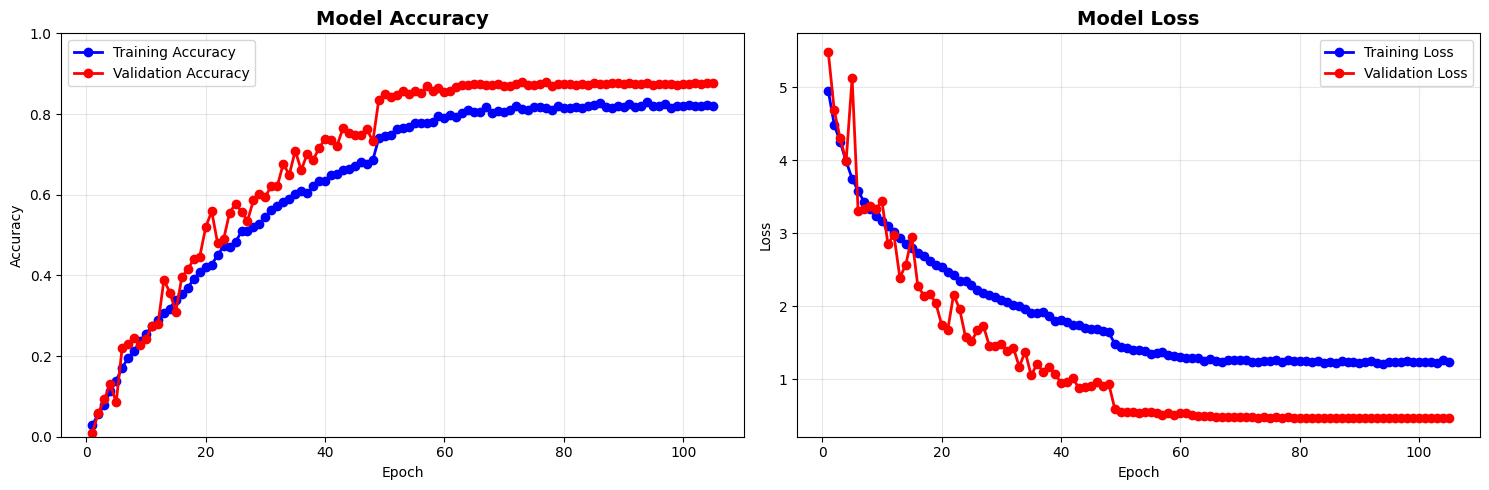

📊 Final Training Metrics:
  Training Accuracy: 0.8209
  Validation Accuracy: 0.8759
  Training Loss: 1.2348
  Validation Loss: 0.4669
  Total epochs trained: 105


In [19]:
def plot_training_curves(history_dict=None):
    """
    Plot training curves from history
    """
    # Try to load history from file if not provided
    if history_dict is None:
        history_dict = load_training_history()
    
    if history_dict is None:
        print("❌ No training history found!")
        return
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history_dict['accuracy']) + 1)
    
    # Plot accuracy
    ax1.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot loss
    ax2.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history_dict['accuracy'][-1] if history_dict['accuracy'] else 0
    final_val_acc = history_dict['val_accuracy'][-1] if history_dict['val_accuracy'] else 0
    final_train_loss = history_dict['loss'][-1] if history_dict['loss'] else 0
    final_val_loss = history_dict['val_loss'][-1] if history_dict['val_loss'] else 0
    
    print("📊 Final Training Metrics:")
    print(f"  Training Accuracy: {final_train_acc:.4f}")
    print(f"  Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Training Loss: {final_train_loss:.4f}")
    print(f"  Validation Loss: {final_val_loss:.4f}")
    print(f"  Total epochs trained: {len(history_dict['accuracy'])}")

# Plot training curves
try:
    # If we just finished training, use the history object
    if 'history' in locals() and hasattr(history, 'history'):
        plot_training_curves(history.history)
    else:
        # Otherwise, load from file
        plot_training_curves()
except Exception as e:
    print(f"Error plotting training curves: {e}")
    print("Trying to load from saved history file...")
    plot_training_curves()

## 9. Evaluate on Test Set với Top-K Accuracy

In [20]:
def calculate_top_k_accuracy(model, generator, k_values=[1, 3, 5]):
    """
    Calculate Top-K accuracy for different values of K
    """
    print("🧮 Calculating Top-K Accuracy...")
    
    # Get all predictions and true labels
    y_pred_proba = model.predict(generator, verbose=1)
    y_true = generator.classes  # 1D array of labels
    
    # Calculate top-k accuracies
    results = {}
    for k in k_values:
        if k <= y_pred_proba.shape[1]:  # Make sure k doesn't exceed number of classes
            top_k_acc = top_k_accuracy_score(
                y_true,           # <-- chỉ dùng labels 1D, không one-hot
                y_pred_proba,
                k=k
            )
            results[f'top_{k}_accuracy'] = top_k_acc
        else:
            results[f'top_{k}_accuracy'] = 1.0  # If k >= num_classes, accuracy is 100%
    
    return results, y_pred_proba, y_true

# Evaluate on test set
print("🎯 Evaluating model on test set...")

# Reset test generator
test_generator.reset()

# Calculate metrics
test_results, y_pred_proba, y_true = calculate_top_k_accuracy(
    model, 
    test_generator, 
    k_values=[1, 3, 5]
)

# Get predicted classes for confusion matrix
y_pred = np.argmax(y_pred_proba, axis=1)

# Print results
print("\n📊 Test Set Evaluation Results:")
print("="*50)
for metric, value in test_results.items():
    print(f"{metric.replace('_', '-').title()}: {value:.4f} ({value*100:.2f}%)")

# Calculate test loss
test_loss = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss[0]:.4f}")
print("="*50)

🎯 Evaluating model on test set...
🧮 Calculating Top-K Accuracy...
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

📊 Test Set Evaluation Results:
Top-1-Accuracy: 0.8717 (87.17%)
Top-3-Accuracy: 0.9431 (94.31%)
Top-5-Accuracy: 0.9681 (96.81%)
Test Loss: 0.5166


## 10. Confusion Matrix và Per-Class Accuracy

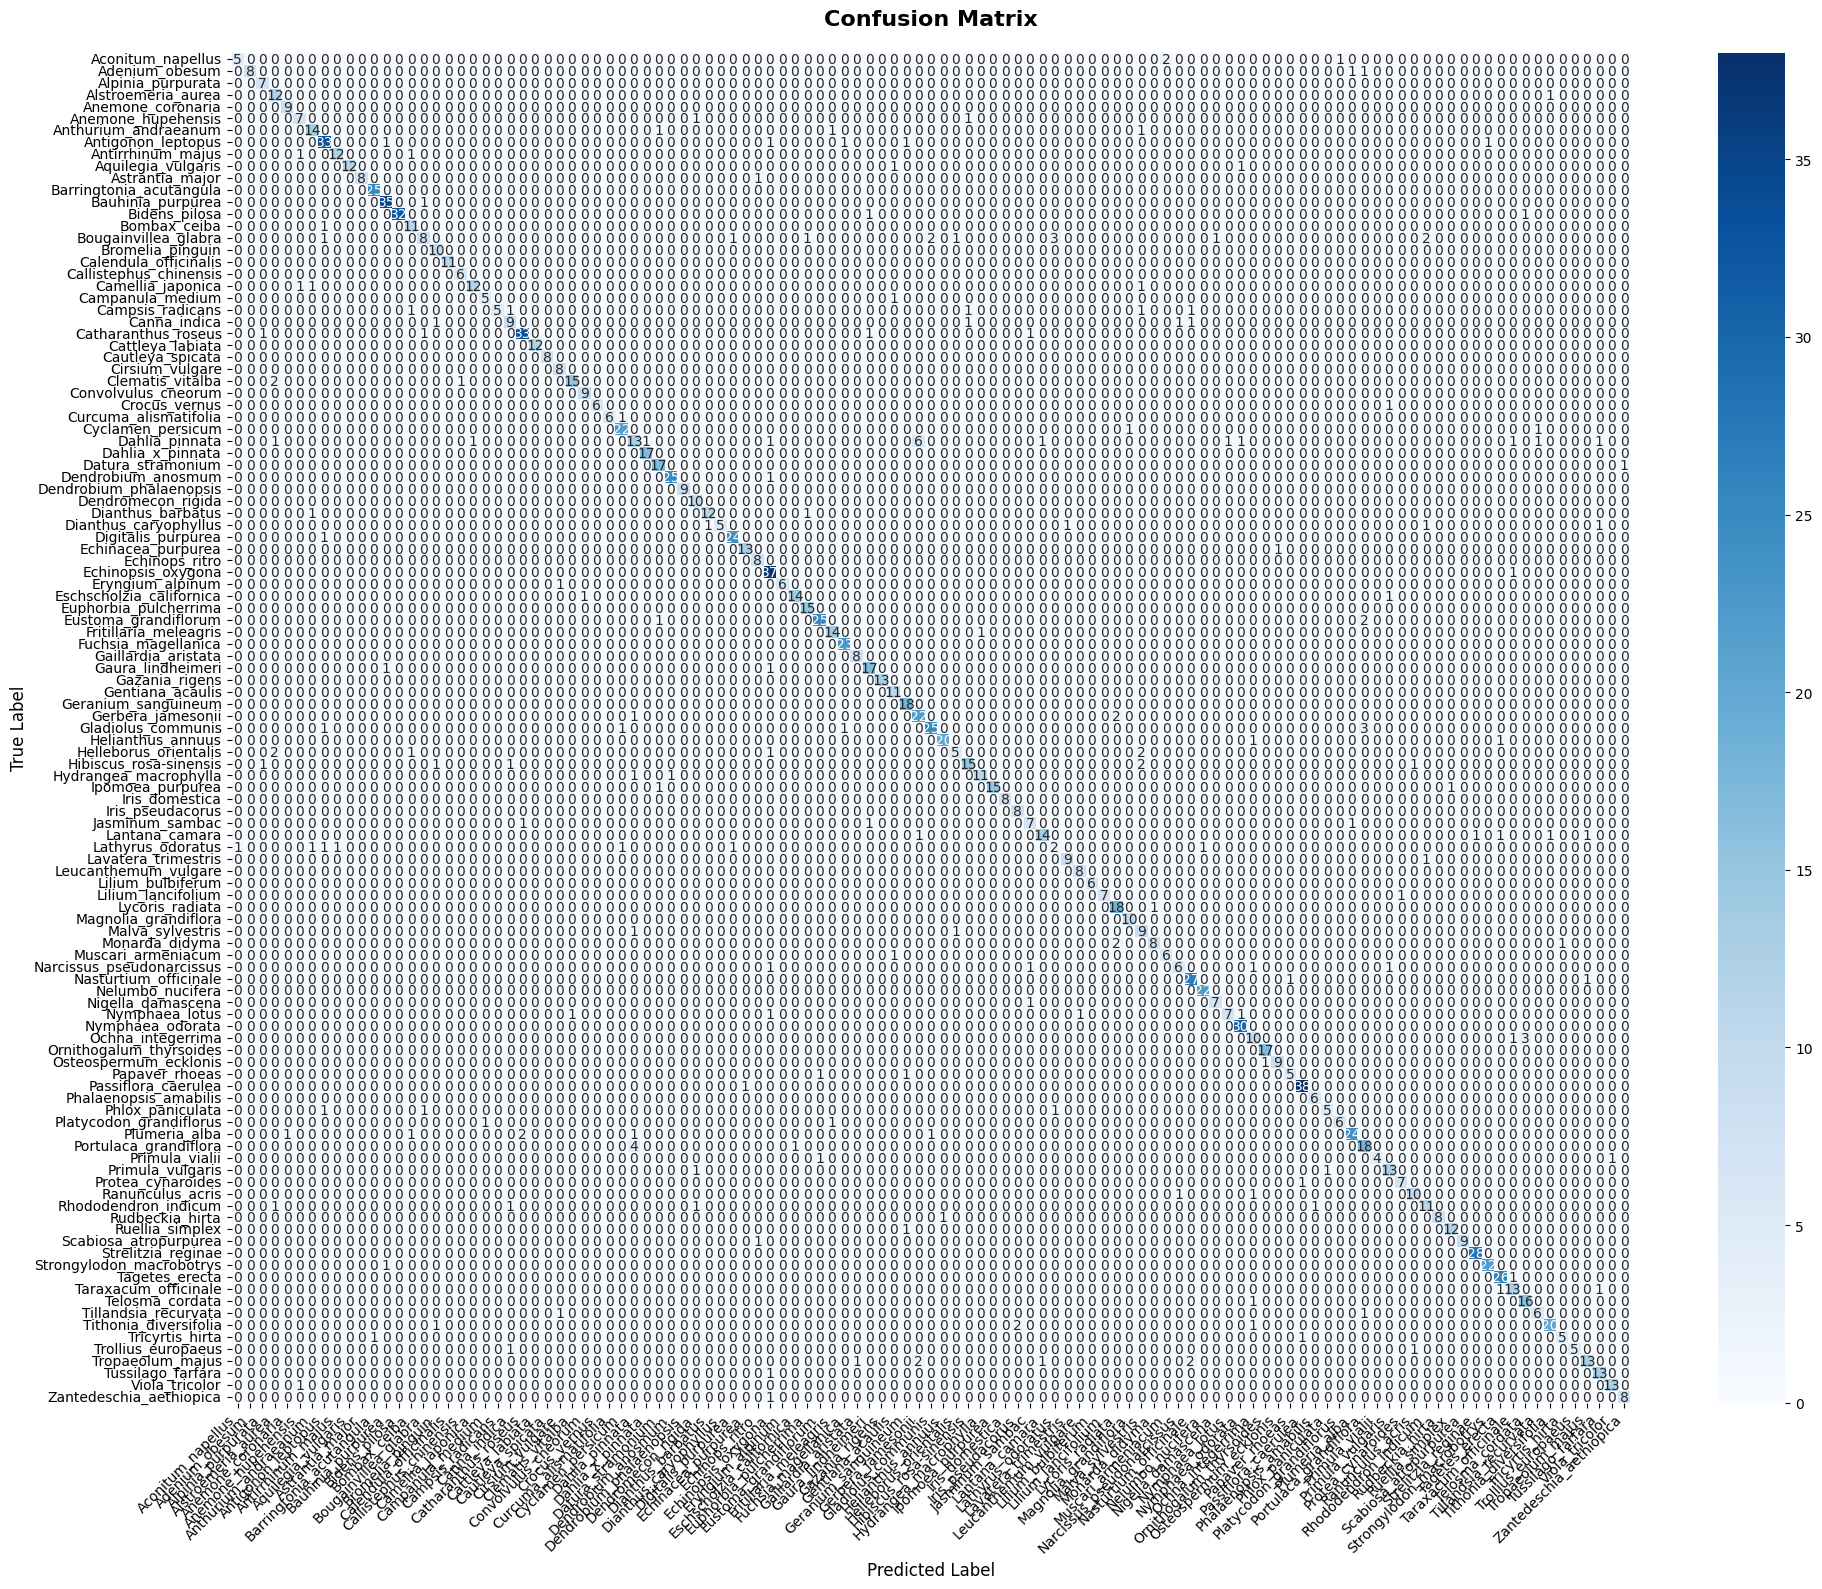


🌺 Per-Class Accuracy Results:
Class Name                     Accuracy   Correct  Total    Percentage
Alpinia_purpurata              1.0000     7        7        100.00%
Anemone_coronaria              1.0000     9        9        100.00%
Barringtonia_acutangula        1.0000     25       25       100.00%
Bromelia_pinguin               1.0000     10       10       100.00%
Calendula_officinalis          1.0000     11       11       100.00%
Callistephus_chinensis         1.0000     6        6        100.00%
Cattleya_labiata               1.0000     12       12       100.00%
Cautleya_spicata               1.0000     8        8        100.00%
Cirsium_vulgare                1.0000     8        8        100.00%
Convolvulus_cneorum            1.0000     9        9        100.00%
Dahlia_x_pinnata               1.0000     17       17       100.00%
Dendrobium_phalaenopsis        1.0000     9        9        100.00%
Dendromecon_rigida             1.0000     10       10       100.00%
Echinops_ritro

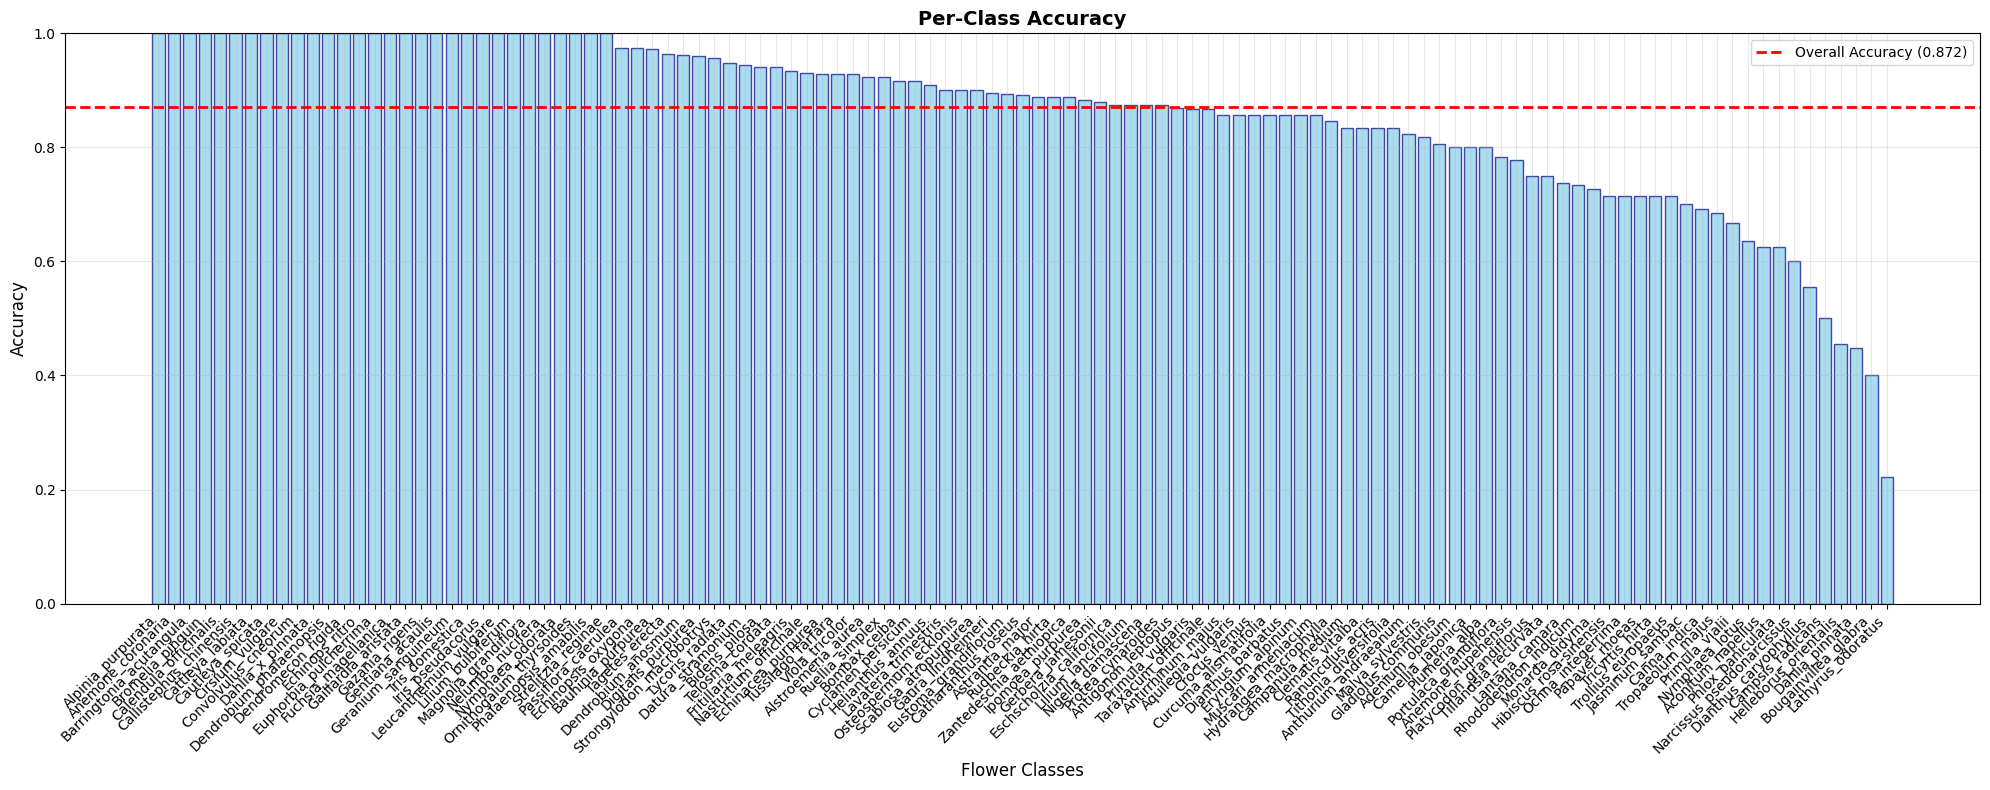

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
def calculate_per_class_accuracy(cm, class_names):
    """
    Calculate accuracy for each class from confusion matrix
    """
    per_class_acc = []
    
    for i in range(len(class_names)):
        # True positives for class i
        tp = cm[i, i]
        # Total samples for class i
        total = np.sum(cm[i, :])
        
        if total > 0:
            accuracy = tp / total
        else:
            accuracy = 0.0
        
        per_class_acc.append({
            'class': class_names[i],
            'accuracy': accuracy,
            'correct': tp,
            'total': total
        })
    
    return per_class_acc

# Calculate per-class accuracy
per_class_results = calculate_per_class_accuracy(cm, class_names)

# Sort by accuracy for better visualization
per_class_results_sorted = sorted(per_class_results, key=lambda x: x['accuracy'], reverse=True)

# Display results
print("\n🌺 Per-Class Accuracy Results:")
print("="*80)
print(f"{'Class Name':<30} {'Accuracy':<10} {'Correct':<8} {'Total':<8} {'Percentage'}")
print("="*80)

for result in per_class_results_sorted:
    accuracy_pct = result['accuracy'] * 100
    print(f"{result['class']:<30} {result['accuracy']:<10.4f} {result['correct']:<8d} {result['total']:<8d} {accuracy_pct:>6.2f}%")

print("="*80)

# Calculate overall statistics
total_correct = sum([r['correct'] for r in per_class_results])
total_samples = sum([r['total'] for r in per_class_results])
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

accuracies = [r['accuracy'] for r in per_class_results]
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
min_accuracy = np.min(accuracies)
max_accuracy = np.max(accuracies)

print(f"\n📊 Summary Statistics:")
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Mean Per-Class Accuracy: {mean_accuracy:.4f} ({mean_accuracy*100:.2f}%)")
print(f"Std Per-Class Accuracy: {std_accuracy:.4f}")
print(f"Min Per-Class Accuracy: {min_accuracy:.4f} ({min_accuracy*100:.2f}%)")
print(f"Max Per-Class Accuracy: {max_accuracy:.4f} ({max_accuracy*100:.2f}%)")

# Find best and worst performing classes
best_class = per_class_results_sorted[0]
worst_class = per_class_results_sorted[-1]

print(f"\n🏆 Best performing class: {best_class['class']} ({best_class['accuracy']*100:.2f}%)")
print(f"🎯 Worst performing class: {worst_class['class']} ({worst_class['accuracy']*100:.2f}%)")

# Visualize per-class accuracy
plt.figure(figsize=(20, 8))
classes = [r['class'] for r in per_class_results_sorted]
accuracies = [r['accuracy'] for r in per_class_results_sorted]

bars = plt.bar(range(len(classes)), accuracies, color='skyblue', edgecolor='navy', alpha=0.7)

# Add horizontal line for overall accuracy
plt.axhline(y=overall_accuracy, color='red', linestyle='--', linewidth=2, 
            label=f'Overall Accuracy ({overall_accuracy:.3f})')

plt.xlabel('Flower Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Classification Report và Model Summary

In [23]:
# Generate detailed classification report
print("📊 Detailed Classification Report:")
print("="*100)

# Generate classification report
report = classification_report(
    y_true, y_pred, 
    target_names=class_names, 
    output_dict=True,
    zero_division=0
)

# Print formatted report
report_text = classification_report(
    y_true, y_pred, 
    target_names=class_names,
    zero_division=0
)
print(report_text)

# Save all results to files
results_summary = {
    'model_info': {
        'total_parameters': int(model.count_params()),
        'trainable_parameters': int(sum([np.prod(w.shape) for w in model.trainable_weights])),
        'model_type': 'MobileNet',
        'input_shape': list(IMG_SIZE) + [3],
        'num_classes': NUM_CLASSES,
        'batch_size': BATCH_SIZE
    },
    'training_info': existing_state if existing_state else {},
    'test_results': {
        'top_1_accuracy': float(test_results['top_1_accuracy']),
        'top_3_accuracy': float(test_results['top_3_accuracy']),
        'top_5_accuracy': float(test_results['top_5_accuracy']),
        'overall_accuracy': float(overall_accuracy),
        'mean_per_class_accuracy': float(mean_accuracy),
        'std_per_class_accuracy': float(std_accuracy),
        'min_per_class_accuracy': float(min_accuracy),
        'max_per_class_accuracy': float(max_accuracy)
    },
    'per_class_results': per_class_results,
    'classification_report': report,
    'best_performing_class': {
        'name': best_class['class'],
        'accuracy': float(best_class['accuracy'])
    },
    'worst_performing_class': {
        'name': worst_class['class'],
        'accuracy': float(worst_class['accuracy'])
    },
    'timestamp': datetime.now().isoformat()
}

# Save results
results_path = os.path.join(CHECKPOINT_DIR, 'evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=lambda x: int(x) if isinstance(x, (np.integer,)) 
                                                 else float(x) if isinstance(x, (np.floating,)) 
                                                 else str(x))

print(f"\n💾 Results saved to: {results_path}")

# Final summary
print("\n🎉 TRAINING AND EVALUATION COMPLETED!")
print("="*70)
print("📁 Generated Files:")
print(f"  ✅ Best model weights: {WEIGHTS_PATH}")
print(f"  ✅ Final model: {os.path.join(CHECKPOINT_DIR, 'final_model.h5')}")
print(f"  ✅ Training history: {HISTORY_PATH}")
print(f"  ✅ Training state: {STATE_PATH}")
print(f"  ✅ Evaluation results: {results_path}")
print("="*70)
print("🌺 Key Performance Metrics:")
print(f"  🎯 Top-1 Accuracy: {test_results['top_1_accuracy']*100:.2f}%")
print(f"  🎯 Top-3 Accuracy: {test_results['top_3_accuracy']*100:.2f}%")
print(f"  🎯 Top-5 Accuracy: {test_results['top_5_accuracy']*100:.2f}%")
print(f"  📊 Mean Per-Class Accuracy: {mean_accuracy*100:.2f}%")
print(f"  🏆 Best Class: {best_class['class']} ({best_class['accuracy']*100:.2f}%)")
print(f"  🎯 Worst Class: {worst_class['class']} ({worst_class['accuracy']*100:.2f}%)")
print("="*70)

📊 Detailed Classification Report:
                           precision    recall  f1-score   support

        Aconitum_napellus       0.83      0.62      0.71         8
           Adenium_obesum       1.00      0.80      0.89        10
        Alpinia_purpurata       0.78      1.00      0.88         7
       Alstroemeria_aurea       0.67      0.92      0.77        13
        Anemone_coronaria       0.90      1.00      0.95         9
       Anemone_hupehensis       0.70      0.78      0.74         9
     Anthurium_andraeanum       0.82      0.82      0.82        17
       Antigonon_leptopus       0.85      0.87      0.86        38
        Antirrhinum_majus       0.92      0.86      0.89        14
       Aquilegia_vulgaris       1.00      0.86      0.92        14
          Astrantia_major       1.00      0.89      0.94         9
  Barringtonia_acutangula       0.96      1.00      0.98        25
        Bauhinia_purpurea       0.92      0.97      0.95        36
            Bidens_pilosa  